# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset dengan ketentuan sebagai berikut:

1. **Sumber Dataset**: Kaggle = https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset  
   Dataset yang saya gunakan adalah SMS Spam Collection Dataset  
   Dataset yang digunakan bersumber dari Kaggle, yang merupakan repositori data global. Dataset ini berisi ribuan sampel pesan email yang telah dikategorikan secara manual menjadi dua kelas:

a. Tujuan: Membangun model klasifikasi biner untuk membedakan email sah (Ham) dan email yang tidak diinginkan (Spam).
   - Ham: Email normal atau legal (seperti korespondensi kerja, pesan teman, atau notifikasi resmi).

   - Spam: Email yang tidak diinginkan, biasanya berisi promosi, penipuan (phishing), atau lampiran berbahaya.

b. Jenis Data: Dataset teks (NLP) yang terdiri dari dua kolom utama: label kategori (ham/spam) dan konten pesan mentah (message).

c. Isi Dataset: Berupa kumpulan pesan teks pendek maupun panjang yang telah diproses menggunakan TF-IDF untuk mengubah kata menjadi bobot numerik.

d. Tujuan Preprocessing: Menghilangkan derau (angka, tanda baca, stopwords) agar model fokus pada kata-kata kunci yang mengindikasikan pola spam (seperti: "win", "free", "claim").a




# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning atau deep learning.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import joblib
import os

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

Jika dataset berupa unstructured data, silakan sesuaikan dengan format seperti kelas Machine Learning Pengembangan atau Machine Learning Terapan

In [ ]:
dataset_path = "SpamEmail_raw\SpamEmail.csv"

df = pd.read_csv(dataset_path, encoding="latin-1")

# Ambil kolom penting saja
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

print(df.head())


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [11]:
print("Shape dataset:", df.shape)
df.head()

Shape dataset: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


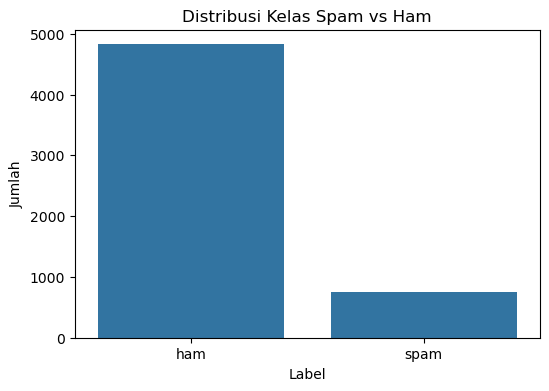

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title("Distribusi Kelas Spam vs Ham")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()


In [14]:
df['label'].value_counts(normalize=True) * 100

label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

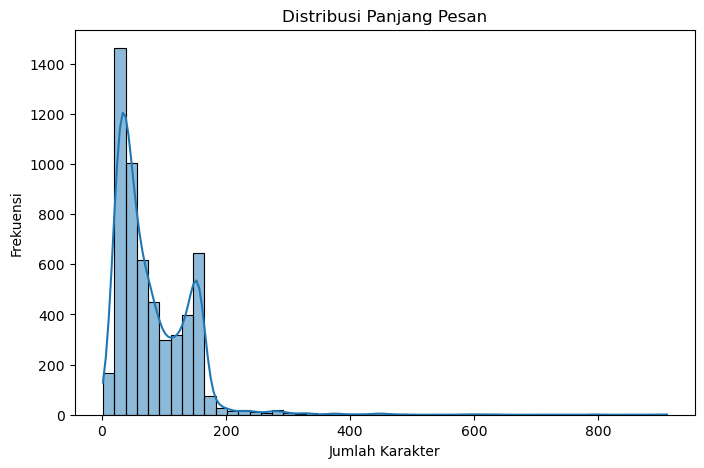

In [15]:
df['message_length'] = df['message'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(df['message_length'], bins=50, kde=True)
plt.title("Distribusi Panjang Pesan")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Frekuensi")
plt.show()

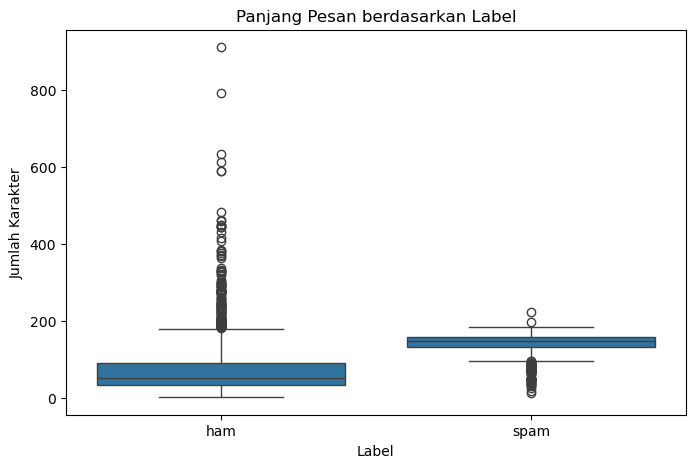

In [16]:
plt.figure(figsize=(8,5))
sns.boxplot(x='label', y='message_length', data=df)
plt.title("Panjang Pesan berdasarkan Label")
plt.xlabel("Label")
plt.ylabel("Jumlah Karakter")
plt.show()

In [17]:
df.groupby('label')['message_length'].mean()

label
ham      71.023627
spam    138.866131
Name: message_length, dtype: float64

In [18]:
print("Contoh HAM:")
print(df[df['label'] == 'ham']['message'].iloc[0])

print("\nContoh SPAM:")
print(df[df['label'] == 'spam']['message'].iloc[0])

Contoh HAM:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Contoh SPAM:
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


## Kesimpulan

1. Dataset memiliki 2 kelas: spam dan ham
2. Dataset imbalanced
3. Pesan spam cenderung lebih panjang
4. Data bersih (tanpa missing value)
5. Cocok untuk klasifikasi teks

# **5. Data Preprocessing**

In [21]:
print(df.columns)

Index(['label', 'message', 'message_length'], dtype='object')


Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning.

Jika Anda menggunakan data teks, data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah. Khususnya ketika kami menggunakan data tidak terstruktur.

In [23]:
nltk.download('stopwords')
stop_words = stopwords.words('english')


def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)


# =========================
# PREPROCESSING
# =========================
df['clean_text'] = df['message'].apply(clean_text)

# Encode label
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text'])
y = df['label_encoded']

# =========================
# TRAIN - TEST SPLIT
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

[nltk_data] Downloading package stopwords to C:\Users\ElRoy
[nltk_data]     Sinaga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


X_train shape: (4457, 5000)
X_test shape: (1115, 5000)


In [ ]:

# Buat folder output
os.makedirs("SpamEmail_preprocessing", exist_ok=True)

# 1. Simpan tetap sebagai .pkl (untuk model/objek Python)
joblib.dump(tfidf, "SpamEmail_preprocessing/tfidf_vectorizer.pkl")
joblib.dump(le, "SpamEmail_preprocessing/label_encoder.pkl")

# 2. Simpan hasil split sebagai .csv
pd.DataFrame(X_train.toarray()).to_csv("SpamEmail_preprocessing/X_train.csv", index=False)
pd.DataFrame(X_test.toarray()).to_csv("SpamEmail_preprocessing/X_test.csv", index=False)

# Untuk label y (target), bisa langsung diubah ke DataFrame
pd.DataFrame(y_train, columns=['label']).to_csv("SpamEmail_preprocessing/y_train.csv", index=False)
pd.DataFrame(y_test, columns=['label']).to_csv("SpamEmail_preprocessing/y_test.csv", index=False)

print("✅ Preprocessed data berhasil disimpan dalam format .csv")

✅ Preprocessed data berhasil disimpan
